In [5]:
import time
import os
import subprocess
import sys
sys.path.insert(1, '/home/jupyter/datasets/genformer')
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf

import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.models.aformer_atac as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers

import training_utils_atac as training_utils

from scipy import stats
import kipoiseq

import analysis.scripts.interval_and_plotting_utilities as utils

mixed_precision.set_global_policy('mixed_bfloat16')

2023-11-01 03:24:02.251956: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 03:24:05.311196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 03:24:05.377458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 03:24:10.686967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/envs/3.8_env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please

In [6]:
model = utils.model("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_524k_load-False_LR-0.0002_T-7_TF-True_2023-10-27_23:43:30/iteration_26/saved_model")

ran test input
loaded weights


In [7]:
SEQUENCE_LENGTH=524288
resolution=4
num_bins = SEQUENCE_LENGTH // resolution
fasta_file = '/home/jupyter/reference/align_refs/GRCh38/hg38_erccpatch.fa'
fasta_extractor = utils.FastaStringExtractor(fasta_file)

In [8]:
interval = "chr19:35,247,582-35,249,104"
atac_file="/home/jupyter/datasets/processed_genformer_data/ATAC/HG_K562.bed.gz"
tf_arr='/home/jupyter/datasets/processed_genformer_data/ATAC/HG_K562.tf.acc.txt'
output_length = num_bins // 32 
crop_size=(output_length - 896)//2
mask_indices='2040-2056'

mask = np.zeros((1,896,1))
for k in range(896):
    if k in range(440,456):
        mask[0,k,0]=1

inputs, target_atac,masked_atac_reshape= \
    utils.return_all_inputs(interval, atac_file, SEQUENCE_LENGTH,
                      num_bins, resolution,tf_arr,crop_size,output_length,
                      fasta_extractor,mask_indices)

seq_grads, atac_grads,full_grads, prediction,att_matrices = model.contribution_input_grad(inputs, mask)

In [9]:
interval = "chr19:35,247,582-35,249,104"
atac_file="/home/jupyter/datasets/processed_genformer_data/ATAC/HG_A375.bed.gz"
tf_arr='/home/jupyter/datasets/processed_genformer_data/ATAC/HG_A375.tf.acc.txt'
output_length = num_bins // 32 
crop_size=(output_length - 896)//2
mask_indices='2041-2054'

mask = np.zeros((1,896,1))
for k in range(896):
    if k in range(441,454):
        mask[0,k,0]=1

inputs_2, target_atac_2,masked_atac_reshape_2= \
    utils.return_all_inputs(interval, atac_file, SEQUENCE_LENGTH,
                      num_bins, resolution,tf_arr,crop_size,output_length,
                      fasta_extractor,mask_indices)

seq_grads_2, atac_grads_2,full_grads_2, prediction_2,att_matrices_2 = model.contribution_input_grad(inputs_2, mask)

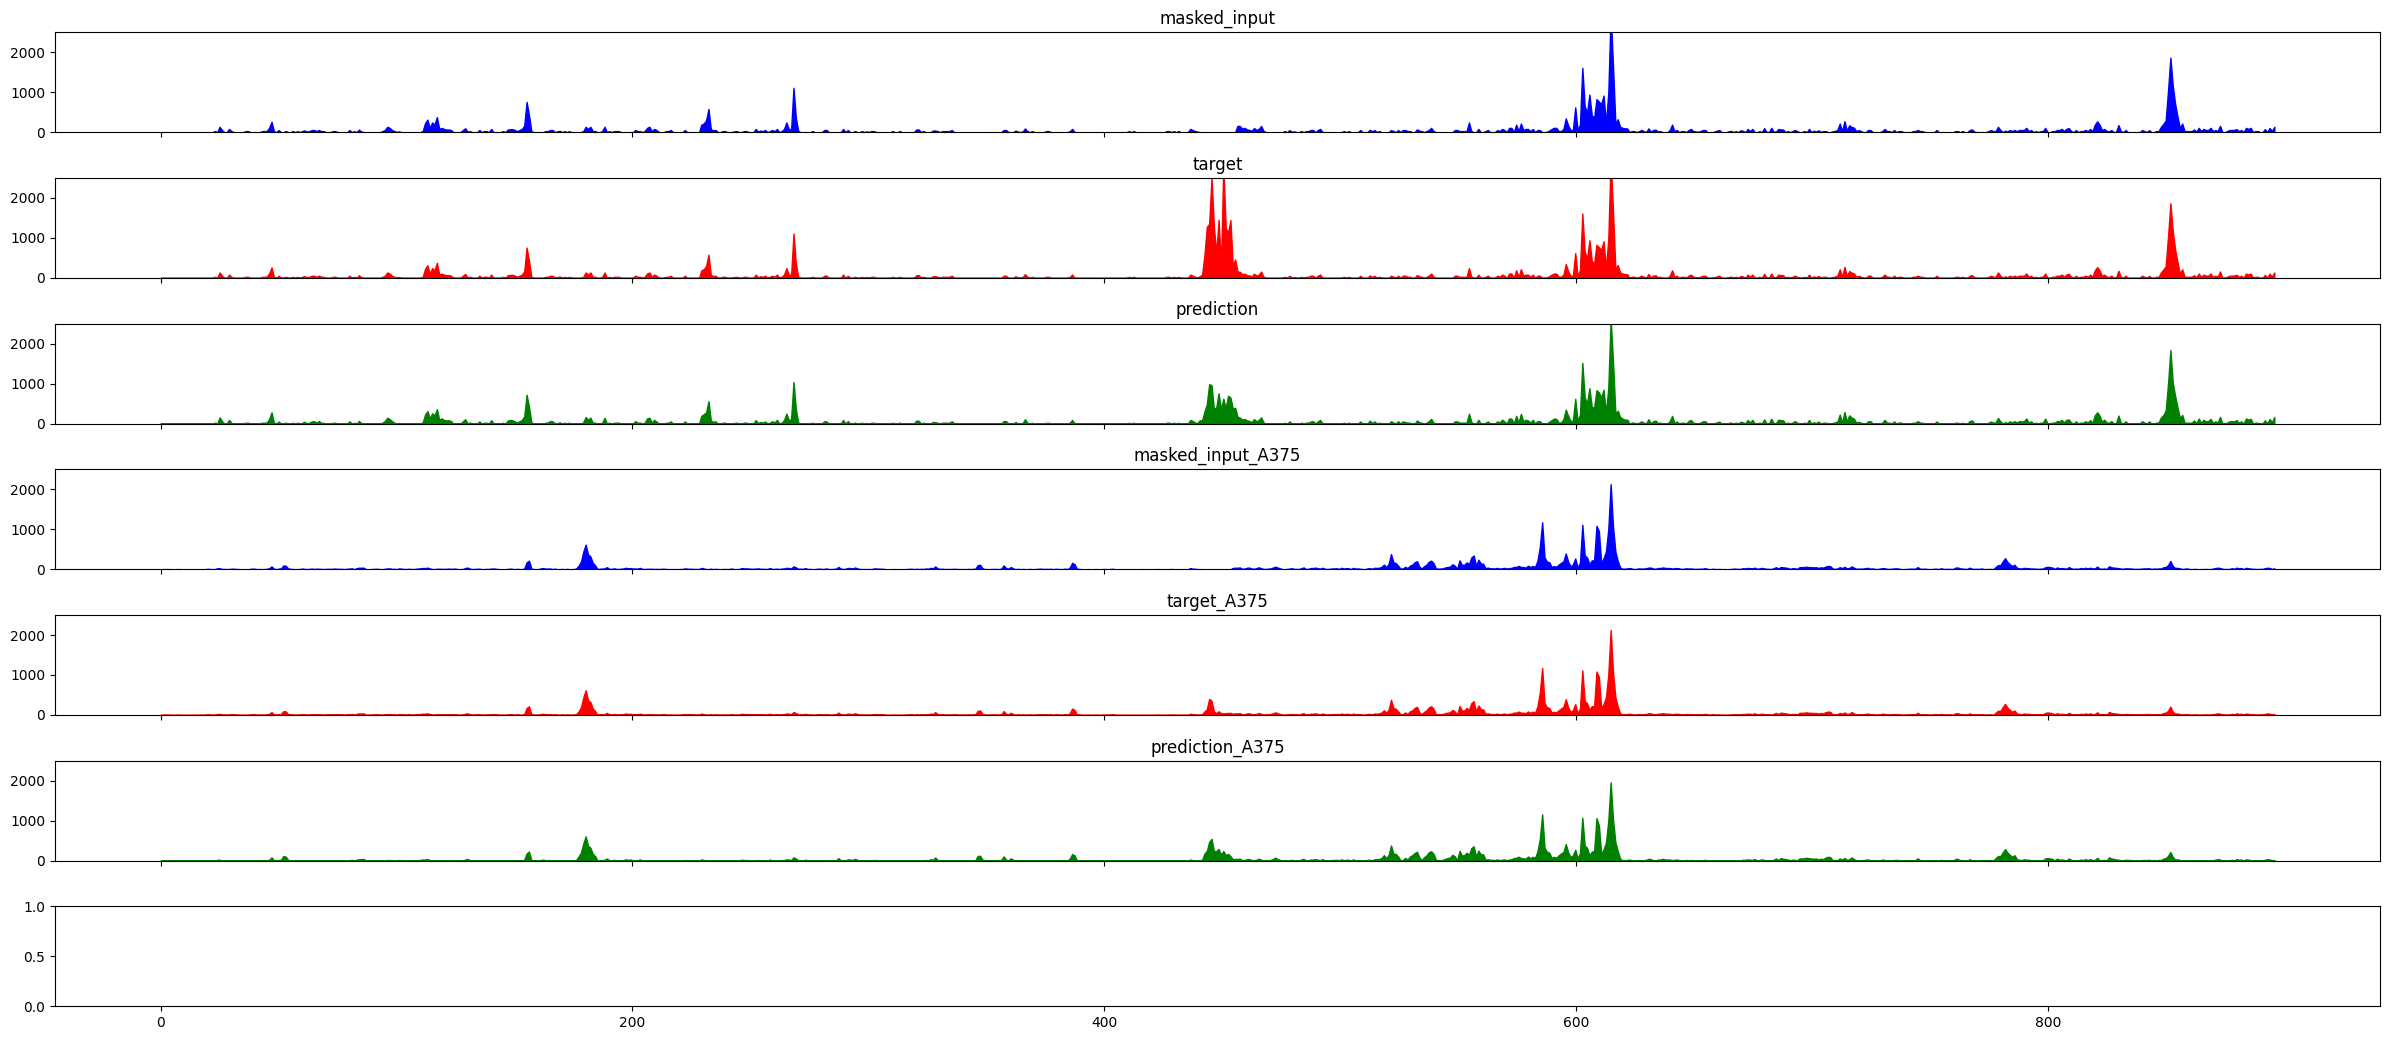

In [14]:
tracks={'masked_input': (masked_atac_reshape[:,0],'blue'),
        'target': (target_atac[:,0],'red'),
        'prediction': (prediction[0,:,0], 'green'),
        'masked_input_A375': (masked_atac_reshape_2[:,0],'blue'),
        'target_A375': (target_atac_2[:,0],'red'),
        'prediction_A375': (prediction_2[0,:,0], 'green')}
utils.plot_tracks(tracks,0,896,2500)

/tmp/ipykernel_23272/329631275.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


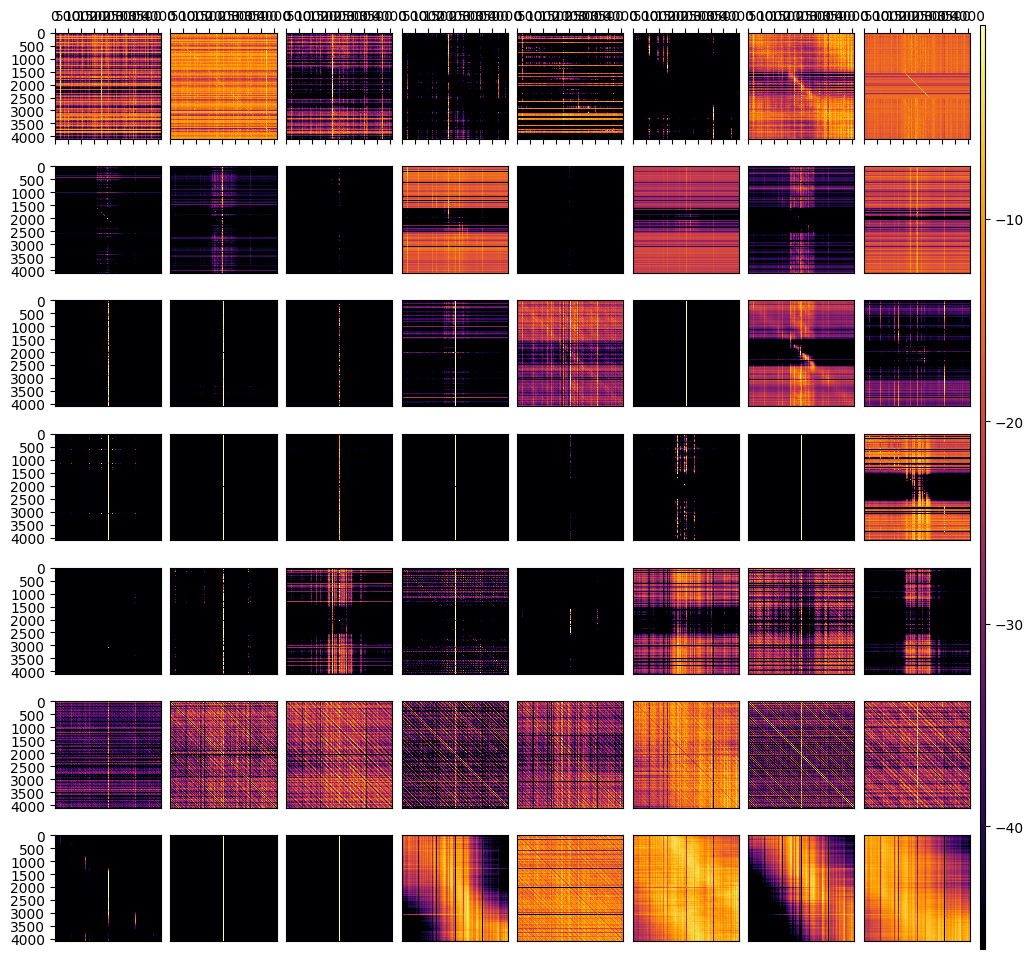

In [15]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(7, 9, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.05], wspace=0.1, hspace=0.1)
for idx in range(7):
    k_1,q_1 = att_matrices['layer_' + str(idx)]
    
    for i in range(0,8):
        prod = tf.matmul(q_1[:-1,0,i,:],tf.transpose(k_1[:-1,0,i,:])) 
        logits = prod / tf.math.sqrt(256.0)
        att = tf.nn.softmax(logits,axis=-1)
        #all_arrs.append(tf.expand_dims(att,axis=0))

        #all_arrs_concat = tf.concat(all_arrs, axis=0)
        #mean_att = np.clip(tf.reduce_mean(all_arrs_concat,axis=0).numpy(),0,0.05)
        ax = plt.subplot(gs[idx, i])
        cax = ax.matshow(np.log(1.0e-20 + att), cmap='inferno')
        # Hide axes for all except leftmost column and bottom-most row
        if idx > 0:
            ax.get_xaxis().set_visible(False)
        if i > 0:
            ax.get_yaxis().set_visible(False)
            
plt.subplots_adjust(wspace=-1.0, hspace=-1.0)

cbar_ax = plt.subplot(gs[:, -1])
plt.colorbar(cax, cax=cbar_ax)
plt.tight_layout()
plt.show()
        

/tmp/ipykernel_23272/3628754562.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


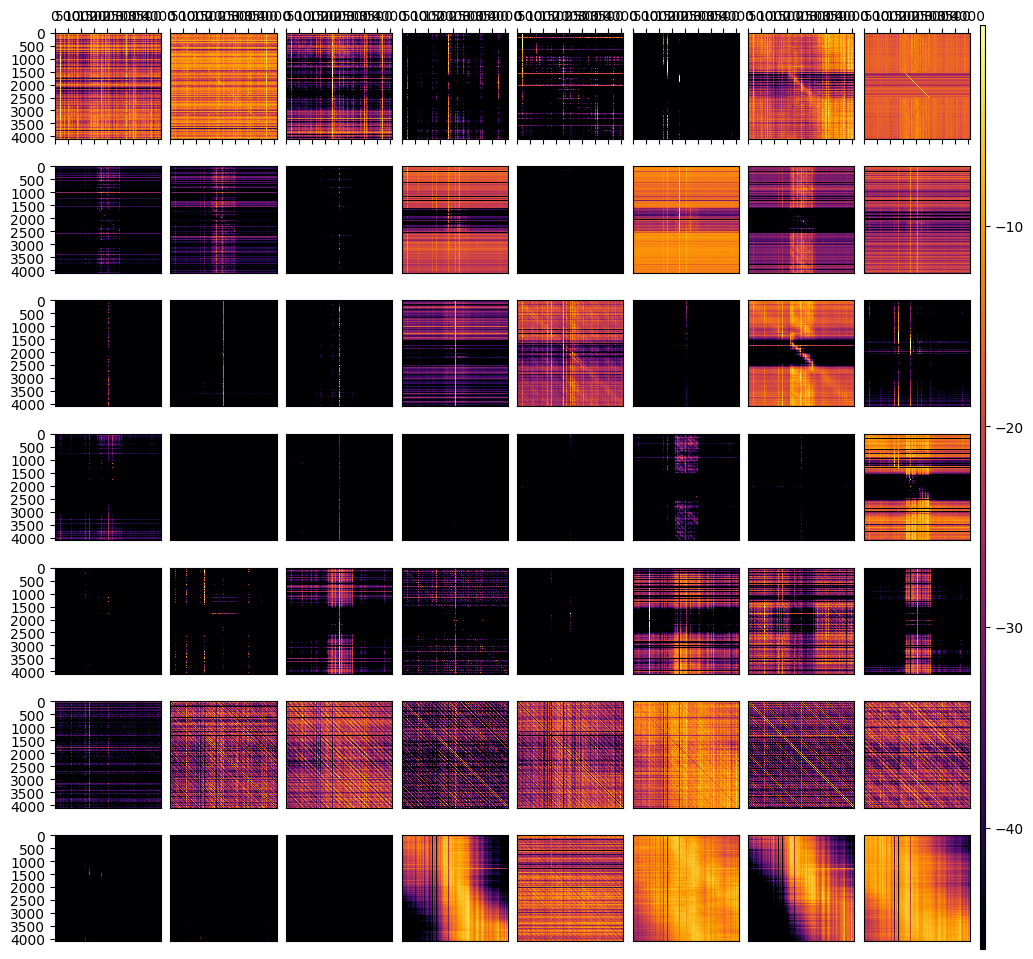

In [16]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(7, 9, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.05], wspace=0.1, hspace=0.1)
for idx in range(7):
    k_1,q_1 = att_matrices_2['layer_' + str(idx)]
    
    for i in range(0,8):
        prod = tf.matmul(q_1[:-1,0,i,:],tf.transpose(k_1[:-1,0,i,:])) 
        logits = prod / tf.math.sqrt(256.0)
        att = tf.nn.softmax(logits,axis=-1)
        #all_arrs.append(tf.expand_dims(att,axis=0))

        #all_arrs_concat = tf.concat(all_arrs, axis=0)
        #mean_att = np.clip(tf.reduce_mean(all_arrs_concat,axis=0).numpy(),0,0.05)
        ax = plt.subplot(gs[idx, i])
        cax = ax.matshow(np.log(1.0e-20 + att), cmap='inferno')
        # Hide axes for all except leftmost column and bottom-most row
        if idx > 0:
            ax.get_xaxis().set_visible(False)
        if i > 0:
            ax.get_yaxis().set_visible(False)
            
plt.subplots_adjust(wspace=-1.0, hspace=-1.0)

cbar_ax = plt.subplot(gs[:, -1])
plt.colorbar(cax, cax=cbar_ax)
plt.tight_layout()
plt.show()
        

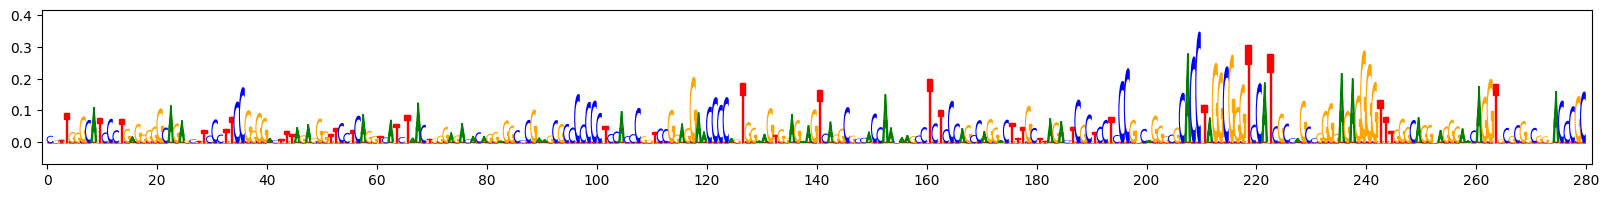

In [17]:
##### import modisco.visualization
from modisco.visualization import viz_sequence
#- tf.reduce_mean(full_grads_out[1], axis=1,keepdims=True)

grads = tf.math.abs(tf.expand_dims(seq_grads,axis=1) -  tf.reduce_mean(full_grads,axis=1,keepdims=True))
scaled = grads / tf.reduce_max(grads)

arr = (scaled * inputs[0][0,:,:4])[262010:262290,:].numpy()

viz_sequence.plot_weights(arr, 
                          subticks_frequency=20)

In [121]:
inputs[1][]

SyntaxError: invalid syntax (1660509849.py, line 1)

<tf.Tensor: shape=(131072, 1), dtype=bfloat16, numpy=
array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [-0]], dtype=bfloat16)>

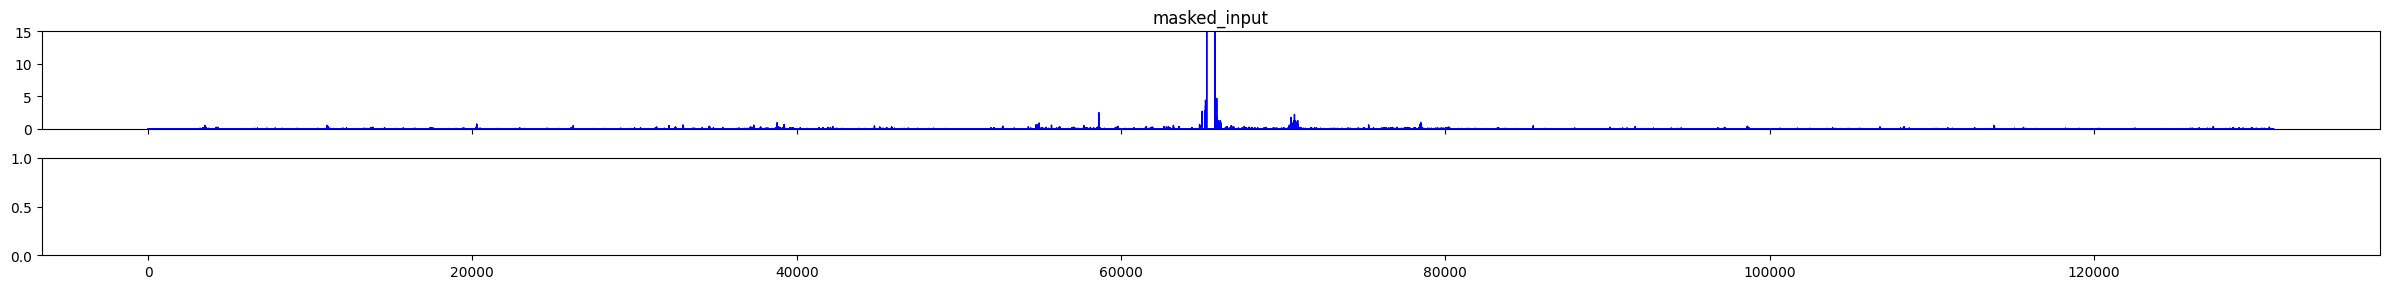

In [18]:
tracks={'masked_input': (atac_grads[:,0],'blue'),
       }
utils.plot_tracks(tracks,0,131072,15)